In [2]:
import tifffile
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd

In [3]:
base_path = r"R:\FIVE\EXP\FIV925\Additional Datasets"

# colon cancer data
dataset = "Human Colon Cancer"
ome_tiff_path = f"{base_path}\\{dataset}\\Visium_HD_Human_Colon_Cancer_image.tif"

# lung cancer data
# dataset = "Human Lung Cancer"
# ome_tiff_path = f"{base_path}\\{dataset}\\morphology_mip.ome.tif"

scale_factor = 1

# so this is a "TiffFile" type 
#   what is that?
tif = tifffile.TiffFile(ome_tiff_path)
# this is turned into this numpy array, and for some reason the lung cancer (morphology_mip.ome.tif) image is different dimensions than the colon cancer image (Visium_HD_Human_Colon_Cancer_image.tif)
#   oh, I think it's cuz the lung cancer image is b/w while the colon cancer image is color
#       so, perhaps I need to change the colon cancer image to b/w?
#       well, we should be able to segment a color image regardless
#   I think I have to get just one of the channels
#   it looks like there are 3 channels?
image = tif.asarray()
image_data = image[::2, ::2]

# rescale to 8bit, but this doesn't actually do anything because image_data is already 8bit
max_val_16bit = np.max(image_data)
image_scaled = (image_data / max_val_16bit) * 255
image_8bit = image_scaled.astype(np.uint8)

ok so the colon cancer data is an image represented as an RGB image
	- the lung cancer data is represented as an array of shape (24097, 21234)

In [4]:
image_dims = image.shape
print("tif type:", type(tif))
print("image type:", type(image))
print("shape of image:", image_dims)
print("the shape of the image is represented as a:", type(image_dims))
print("the first entry in image is:", image[0][0])
print("are image_data and image_8bit the same? " + ("yes" if np.array_equal(image_8bit, image_data) else "no")) # could also define np.array_equal above as a bool

tif type: <class 'tifffile.tifffile.TiffFile'>
image type: <class 'numpy.ndarray'>
shape of image: (3000, 3200, 3)
the shape of the image is represented as a: <class 'tuple'>
the first entry in image is: [227 197 210]
are image_data and image_8bit the same? yes


(-0.5, 3199.5, 2999.5, -0.5)

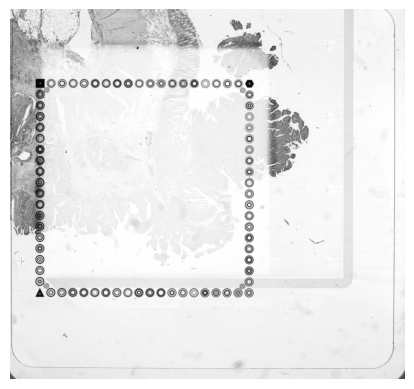

In [5]:
# what does sca mean?
sca = image[:,:,0]
sca = sca / np.quantile(image_data,0.99) # rescale the intensity, if we use max it is way to far outside
sca[sca > 1] = 1
plt.imshow(sca, cmap='gray')
plt.axis('off')  # to hide axis labels and ticks

In [ ]:
tile_size = 384
image_height, image_width = image_dims[0], image_dims[1]
yolo_model_path = r"S:\Phys\FIV925 XSection\Datasets\Brain\01c\YO 432 0515 Yeti\map75=0669758 yolov9c .pt idx=4 ep=8 btch=8 rnd=4229985\weights\best.pt"
model = YOLO(yolo_model_path)
df = pd.DataFrame()

# for each tile in the image ...
# I wanna predict on the tile, and also draw voronoi boxes over it?
#   Ohh, so I need to predict on the image to find the centers of the cells, then use voronoi to draw the boundaries over the cells
for i in range(0, image_height, 384): # section_miny, section_maxy
    for j in range(0, image_width, 384): # section_minx, section_maxx
        tile = image[i:i+tile_size, j:j+tile_size]
        if tile.shape[0] == 0 or tile.shape[1] == 0:
            continue  # Skip tiles that have no width or height
        
        # what is the 'L' for?
        tile_as_img = Image.fromarray(tile, 'L')
        prediction = model.predict(tile_as_img, show=False, max_det=3000)

In [80]:
# first, what does predicting on this image even look like?
yolo_model_path = r"S:\Phys\FIV925 XSection\Datasets\Brain\01c\YO 432 0515 Yeti\map75=0669758 yolov9c .pt idx=4 ep=8 btch=8 rnd=4229985\weights\best.pt"
model = YOLO(yolo_model_path)
prediction = model.predict(ome_tiff_path)
prediction[0].show(labels=False)


image 1/1 R:\FIVE\EXP\FIV925\Additional Datasets\Human Colon Cancer\Visium_HD_Human_Colon_Cancer_image.tif: 448x448 300 1s, 18.5ms
Speed: 2.1ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 448)
